# Installation

In [1]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from sqlalchemy import MetaData, Table

import dateutil.parser
from dateutil.parser import parse
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


# Project Intro

A construction company has an annual maintence at the MTA at the beginning of each winter. The company plans to work during the hours where foot traffic is the least in 4 hour shifts. They have to stop by every station and attempt to not cause congestion in the MTA.

This construction company has ultimitely solicited our involvement to utilize the publically accessible MTA data to optimize the work hours such that they can avoid the most people.

# Goal / Method

Our goal in this presentation is to minimize the impact on foot traffic by doing work during the slowest times in the week.

To do this we will look at the MTA data to determine how much foot traffic is there throughout the week and then look into lower flow days to figure out a good time.

# Things to keep in mind

How long do we have to work on this project?

Do we have multiple teams avaliable to work on different stations at the same time?

# 1. Importing Data

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
# def get_data(week_nums):
#     url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
#     dfs = []
#     for week_num in week_nums:
#         file_url = url.format(week_num)
#         dfs.append(pd.read_csv(file_url))
#     return pd.concat(dfs)
        
# week_nums = [210605,210619,210626,210703,210710,210717,210724,210731,210807,210814,210821,210828]
#mta_df = get_data(week_nums)

In [3]:
engine = create_engine("sqlite:///MTA.sqlite")
mta_df = pd.read_sql('SELECT * FROM turnstile;', engine)

In [4]:
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303505 entries, 0 to 3303504
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 277.2+ MB


In [5]:
mta_df.columns = [column.strip() for column in mta_df.columns]
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303505 entries, 0 to 3303504
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 277.2+ MB


In [6]:
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,00:00:00,REGULAR,5799442,1966041
1,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,04:00:00,REGULAR,5799463,1966044
2,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,08:00:00,REGULAR,5799492,1966079
3,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,12:00:00,REGULAR,5799610,1966155
4,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,16:00:00,REGULAR,5799833,1966214


# Managing Duplicates

In [7]:
mta_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE","TIME"], inplace=True)

# 2. Entry Data

In [8]:
entries_daily = (mta_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False).ENTRIES.first())
entries_daily[["PREV_DATE", "PREV_ENTRIES"]] = (entries_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

entries_daily = entries_daily.reset_index()
entries_daily['DAILY_ENTRIES'] = entries_daily.groupby(['C/A','UNIT','SCP','STATION']).PREV_ENTRIES.diff().shift(-1)

<ipython-input-8-871915b1cc85>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  entries_daily[["PREV_DATE", "PREV_ENTRIES"]] = (entries_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


In [9]:
entries_daily.loc[entries_daily['DAILY_ENTRIES'] <= 0 , 'DAILY_ENTRIES'] = np.nan
entries_daily.loc[entries_daily['DAILY_ENTRIES'] > 100000 , 'DAILY_ENTRIES'] = np.nan
entries_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
entries_daily.head()

,index,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,1,A002,R051,02-00-00,59 ST,05/30/2021,7579078,05/29/2021,7578734.0,344.0
2,2,A002,R051,02-00-00,59 ST,05/31/2021,7579312,05/30/2021,7579078.0,234.0
3,3,A002,R051,02-00-00,59 ST,06/01/2021,7579653,05/31/2021,7579312.0,341.0
4,4,A002,R051,02-00-00,59 ST,06/02/2021,7580250,06/01/2021,7579653.0,597.0
5,5,A002,R051,02-00-00,59 ST,06/03/2021,7580823,06/02/2021,7580250.0,573.0


In [10]:
entries_sum = entries_daily.groupby('STATION')['DAILY_ENTRIES'].sum()
entries_sum.sort_values(ascending=False, inplace=True)
entries_sum.head(10)

STATION
34 ST-PENN STA     6441372.0
GRD CNTRL-42 ST    4978276.0
34 ST-HERALD SQ    4752505.0
23 ST              4195724.0
86 ST              4108006.0
14 ST-UNION SQ     3994509.0
42 ST-PORT AUTH    3769779.0
FULTON ST          3766317.0
TIMES SQ-42 ST     3650266.0
125 ST             3483347.0
Name: DAILY_ENTRIES, dtype: float64

# 3. Exit Data

For now I am having a bug with it so I will use just entries until I can use exit data as well.

In [11]:
exits_daily = (mta_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False).EXITS.first())
exits_daily

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,05/29/2021,2590325
1,A002,R051,02-00-00,59 ST,05/30/2021,2590451
2,A002,R051,02-00-00,59 ST,05/31/2021,2590560
3,A002,R051,02-00-00,59 ST,06/01/2021,2590651
4,A002,R051,02-00-00,59 ST,06/02/2021,2590926
...,...,...,...,...,...,...
550568,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/12/2016,271
550569,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/13/2016,271
550570,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/14/2016,271
550571,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/15/2016,271


In [12]:
exits_daily

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,05/29/2021,2590325
1,A002,R051,02-00-00,59 ST,05/30/2021,2590451
2,A002,R051,02-00-00,59 ST,05/31/2021,2590560
3,A002,R051,02-00-00,59 ST,06/01/2021,2590651
4,A002,R051,02-00-00,59 ST,06/02/2021,2590926
...,...,...,...,...,...,...
550568,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/12/2016,271
550569,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/13/2016,271
550570,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/14/2016,271
550571,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/15/2016,271


In [13]:
exits_daily[["PREV_DATE", "PREV_EXITS"]] = (exits_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"].apply(lambda grp: grp.shift(1)))

exits_daily = exits_daily.reset_index()
exits_daily['DAILY_EXITS'] = exits_daily.groupby(['C/A','UNIT','SCP','STATION']).PREV_EXITS.diff().shift(-1)

<ipython-input-13-0ddf3738e5dc>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  exits_daily[["PREV_DATE", "PREV_EXITS"]] = (exits_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"].apply(lambda grp: grp.shift(1)))


In [14]:
exits_daily.loc[exits_daily['DAILY_EXITS'] <= 0 , 'DAILY_EXITS'] = np.nan
exits_daily.loc[exits_daily['DAILY_EXITS'] > 100000 , 'DAILY_EXITS'] = np.nan
exits_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
exits_daily.head()

,index,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS,DAILY_EXITS
1,1,A002,R051,02-00-00,59 ST,05/30/2021,2590451,05/29/2021,2590325.0,126.0
2,2,A002,R051,02-00-00,59 ST,05/31/2021,2590560,05/30/2021,2590451.0,109.0
3,3,A002,R051,02-00-00,59 ST,06/01/2021,2590651,05/31/2021,2590560.0,91.0
4,4,A002,R051,02-00-00,59 ST,06/02/2021,2590926,06/01/2021,2590651.0,275.0
5,5,A002,R051,02-00-00,59 ST,06/03/2021,2591203,06/02/2021,2590926.0,277.0


In [15]:
exits_sum = exits_daily.groupby('STATION')['DAILY_EXITS'].sum()
exits_sum.sort_values(ascending=False, inplace=True)
exits_sum.head(10)

STATION
34 ST-PENN STA     7364314.0
GRD CNTRL-42 ST    6089075.0
34 ST-HERALD SQ    5751520.0
86 ST              5033255.0
14 ST-UNION SQ     4821583.0
23 ST              4583947.0
TIMES SQ-42 ST     4345676.0
FULTON ST          4305761.0
42 ST-PORT AUTH    4245446.0
125 ST             4041375.0
Name: DAILY_EXITS, dtype: float64

# 4. Total Traffic
Will be finished when exit data can be solved

In [16]:
df_total_traffic = entries_sum.add(exits_sum, fill_value = 0)
df_total_traffic.sort_values(ascending=False,inplace=True)
df_total_traffic.head(10)

STATION
34 ST-PENN STA     13805686.0
GRD CNTRL-42 ST    11067351.0
34 ST-HERALD SQ    10504025.0
86 ST               9141261.0
14 ST-UNION SQ      8816092.0
23 ST               8779671.0
FULTON ST           8072078.0
42 ST-PORT AUTH     8015225.0
TIMES SQ-42 ST      7995942.0
125 ST              7524722.0
dtype: float64

Text(0, 0.5, 'Total Traffic')

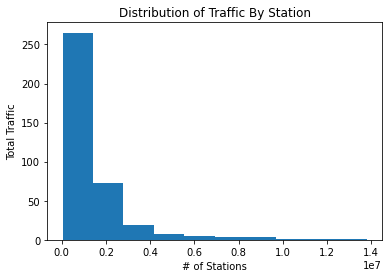

In [17]:
# Histogram

plt.hist(df_total_traffic)
plt.title("Distribution of Traffic By Station")
plt.xlabel("# of Stations")
plt.ylabel("Total Traffic")

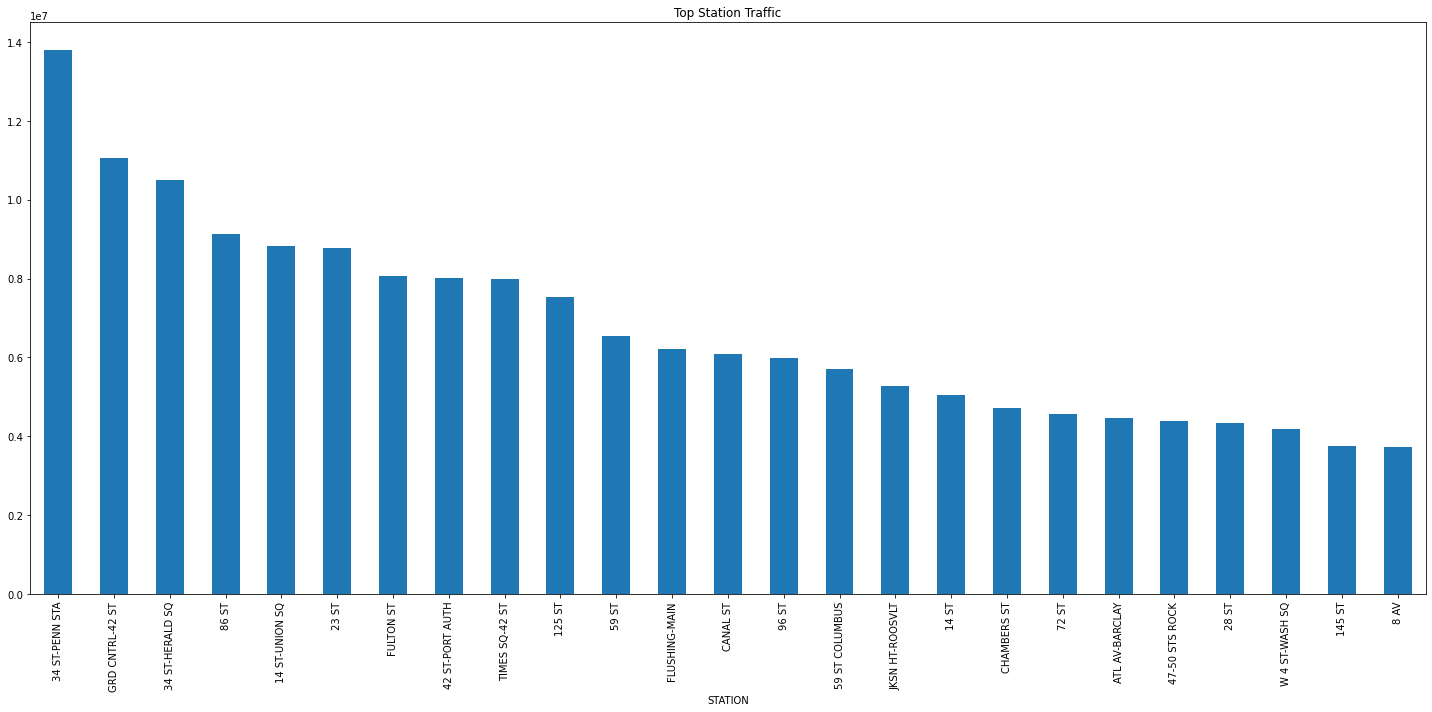

In [18]:
top_25 = df_total_traffic.head(25)

top_25.plot(kind='bar',figsize=(20,10),title = 'Top Station Traffic')

plt.tight_layout()
plt.savefig("Top_25.png")

# Top 5 Stations

In [19]:
df_top = mta_df.loc[(mta_df['STATION']=='34 ST-PENN STA') | (mta_df['STATION']=="34 ST-HERALD SQ") | (mta_df['STATION']=="GRD CNTRL-42 ST") | (mta_df['STATION']=="86 ST") | (mta_df['STATION']=="14 ST-UNION SQ")]

In [20]:
df_top['DATE'] = pd.to_datetime(df_top['DATE'])

<ipython-input-20-708a7bcfd9b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['DATE'] = pd.to_datetime(df_top['DATE'])


In [21]:
df_top["DOW"] = df_top['DATE'].dt.dayofweek

<ipython-input-21-ba6cc372a33c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top["DOW"] = df_top['DATE'].dt.dayofweek


In [22]:
df_top['PAR_TIME'] = df_top['TIME'].apply(parse)

<ipython-input-22-e382c0690555>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['PAR_TIME'] = df_top['TIME'].apply(parse)


In [23]:
#df_top = df_top[df_top['DOW'].isin([0,1,2,3,4])]

In [24]:
df_top['ENTRIES_DIFF'] = df_top['ENTRIES'].diff(1);
df_top['EXITS_DIFF'] = df_top['EXITS'].diff(1);
df_top['TOTAL_TRAFF'] = df_top['ENTRIES_DIFF'] + df_top["EXITS_DIFF"]

<ipython-input-24-13e580f06155>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['ENTRIES_DIFF'] = df_top['ENTRIES'].diff(1);
<ipython-input-24-13e580f06155>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['EXITS_DIFF'] = df_top['EXITS'].diff(1);
<ipython-input-24-13e580f06155>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [25]:
df_top.loc[df_top['ENTRIES_DIFF'] <= 0.0, 'ENTRIES_DIFF'] = np.nan;
df_top.loc[df_top['ENTRIES_DIFF'] > 10000.0, 'ENTRIES_DIFF'] = np.nan;
df_top.loc[df_top['EXITS_DIFF'] <= 0.0, 'EXITS_DIFF'] = np.nan;
df_top.loc[df_top['EXITS_DIFF'] > 10000.0, 'EXITS_DIFF'] = np.nan;
df_top.loc[df_top['TOTAL_TRAFF'] <= 0.0, 'TOTAL_TRAFF'] = np.nan;
df_top.loc[df_top['TOTAL_TRAFF'] > 100000.0, 'TOTAL_TRAFF'] = np.nan;

/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [26]:
total_per_station = df_top.groupby(by='STATION', as_index = False).sum()[['STATION',"TOTAL_TRAFF"]].sort_values('TOTAL_TRAFF',ascending=False)

In [27]:
total_per_station['WEEKLY_TRAFF'] = total_per_station['TOTAL_TRAFF']/7

In [28]:
top_lst = ["34 ST-PENN STA",
           "34 ST-HERALD SQ",
           "GRD CNTRL-42 ST",
           "86 ST",
           "14 ST-UNION SQ"
          ]
top_stations = df_top[df_top['STATION'].isin(top_lst)]
top_stations = top_stations.groupby(by=['STATION', 'PAR_TIME'], as_index=False).sum()[['STATION', 'PAR_TIME','TOTAL_TRAFF']]
top_stations.set_index('PAR_TIME', drop=True, inplace=True)
top_stations = top_stations.groupby(by=['STATION']).resample('4H').mean()
top_stations = top_stations.reset_index()

In [29]:
top_stations

,STATION,PAR_TIME,TOTAL_TRAFF
0,14 ST-UNION SQ,2021-09-14 00:00:00,1.389922e+06
1,14 ST-UNION SQ,2021-09-14 04:00:00,6.614850e+04
2,14 ST-UNION SQ,2021-09-14 08:00:00,1.436126e+05
3,14 ST-UNION SQ,2021-09-14 12:00:00,9.565810e+05
4,14 ST-UNION SQ,2021-09-14 16:00:00,1.354362e+06
5,14 ST-UNION SQ,2021-09-14 20:00:00,2.639485e+06
6,34 ST-HERALD SQ,2021-09-14 00:00:00,1.552935e+06
7,34 ST-HERALD SQ,2021-09-14 04:00:00,3.207929e+04
8,34 ST-HERALD SQ,2021-09-14 08:00:00,6.865500e+04
9,34 ST-HERALD SQ,2021-09-14 12:00:00,4.766176e+05


In [30]:
stations_by_DOW = df_top[df_top['STATION'].isin(top_lst)]
stations_by_DOW = stations_by_DOW.groupby(by=['STATION', 'DOW'], as_index=False).sum()[['STATION', 'DOW','TOTAL_TRAFF']]
stations_by_DOW

,STATION,DOW,TOTAL_TRAFF
0,14 ST-UNION SQ,0,1261637.0
1,14 ST-UNION SQ,1,1456316.0
2,14 ST-UNION SQ,2,1546910.0
3,14 ST-UNION SQ,3,1508401.0
4,14 ST-UNION SQ,4,1546336.0
5,14 ST-UNION SQ,5,1664137.0
6,14 ST-UNION SQ,6,948753.0
7,34 ST-HERALD SQ,0,1503263.0
8,34 ST-HERALD SQ,1,1767003.0
9,34 ST-HERALD SQ,2,1809698.0


In [31]:
stations_by_DOW.loc[stations_by_DOW['DOW'] == 0, 'label'] = 'Monday'
stations_by_DOW.loc[stations_by_DOW['DOW'] == 1, 'label'] = 'Tuesday'
stations_by_DOW.loc[stations_by_DOW['DOW'] == 2, 'label'] = 'Wednesday'
stations_by_DOW.loc[stations_by_DOW['DOW'] == 3, 'label'] = 'Thursday'
stations_by_DOW.loc[stations_by_DOW['DOW'] == 4, 'label'] = 'Friday'
stations_by_DOW.loc[stations_by_DOW['DOW'] == 5, 'label'] = 'Saturday'
stations_by_DOW.loc[stations_by_DOW['DOW'] == 6, 'label'] = 'Sunday'

/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


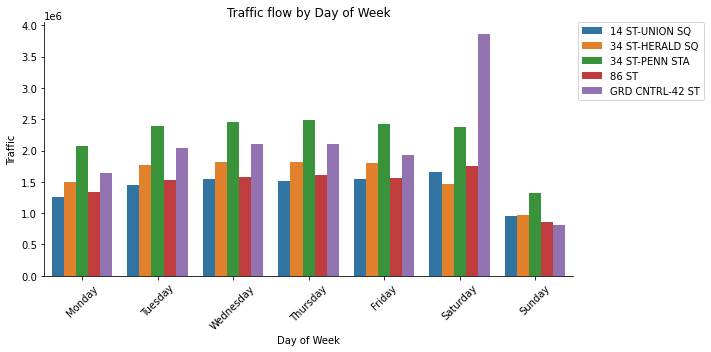

In [41]:
weekday_bar = sns.catplot('label', 'TOTAL_TRAFF', hue ='STATION', kind = 'bar', data = stations_by_DOW, aspect = 2, legend = False)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Traffic')
plt.title('Traffic flow by Day of Week')
plt.legend(bbox_to_anchor=(1.01,1),
           borderaxespad=0)
plt.tight_layout()
plt.savefig("Traffic_DOW.png")

/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


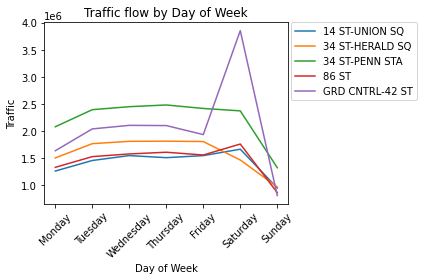

In [44]:
weekday_line = sns.lineplot('label', 'TOTAL_TRAFF', hue ='STATION', data = stations_by_DOW)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Traffic')
plt.title('Traffic flow by Day of Week')
plt.legend(bbox_to_anchor=(1.01,1),
           borderaxespad=0)
plt.tight_layout()
plt.savefig("Traffic_DOW2.png")

In [45]:
top_stations["PEAK_TRAFF"] = top_stations.groupby("STATION")["TOTAL_TRAFF"].transform('max')
top_stations["% of PEAK"] = top_stations['TOTAL_TRAFF']/top_stations['PEAK_TRAFF']
top_stations

,STATION,PAR_TIME,TOTAL_TRAFF,PEAK_TRAFF,% of PEAK
0,14 ST-UNION SQ,2021-09-14 00:00:00,1.389922e+06,2639485.0,0.526588
1,14 ST-UNION SQ,2021-09-14 04:00:00,6.614850e+04,2639485.0,0.025061
2,14 ST-UNION SQ,2021-09-14 08:00:00,1.436126e+05,2639485.0,0.054409
3,14 ST-UNION SQ,2021-09-14 12:00:00,9.565810e+05,2639485.0,0.362412
4,14 ST-UNION SQ,2021-09-14 16:00:00,1.354362e+06,2639485.0,0.513116
5,14 ST-UNION SQ,2021-09-14 20:00:00,2.639485e+06,2639485.0,1.000000
6,34 ST-HERALD SQ,2021-09-14 00:00:00,1.552935e+06,3631797.0,0.427594
7,34 ST-HERALD SQ,2021-09-14 04:00:00,3.207929e+04,3631797.0,0.008833
8,34 ST-HERALD SQ,2021-09-14 08:00:00,6.865500e+04,3631797.0,0.018904
9,34 ST-HERALD SQ,2021-09-14 12:00:00,4.766176e+05,3631797.0,0.131235


In [46]:
stations_by_DOW['PERC_OF_PEAK'] = stations_by_DOW["TOTAL_TRAFF"]/stations_by_DOW.groupby("STATION")["TOTAL_TRAFF"].transform('max')
stations_by_DOW

,STATION,DOW,TOTAL_TRAFF,label,PERC_OF_PEAK
0,14 ST-UNION SQ,0,1261637.0,Monday,0.758133
1,14 ST-UNION SQ,1,1456316.0,Tuesday,0.875118
2,14 ST-UNION SQ,2,1546910.0,Wednesday,0.929557
3,14 ST-UNION SQ,3,1508401.0,Thursday,0.906416
4,14 ST-UNION SQ,4,1546336.0,Friday,0.929212
5,14 ST-UNION SQ,5,1664137.0,Saturday,1.000000
6,14 ST-UNION SQ,6,948753.0,Sunday,0.570117
7,34 ST-HERALD SQ,0,1503263.0,Monday,0.829370
8,34 ST-HERALD SQ,1,1767003.0,Tuesday,0.974879
9,34 ST-HERALD SQ,2,1809698.0,Wednesday,0.998435


/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


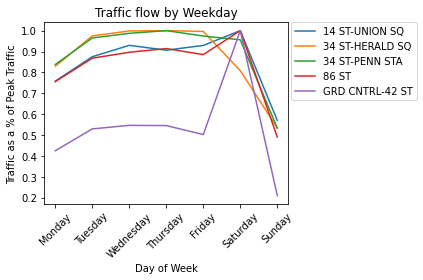

In [47]:
weekday_line_as_perc = sns.lineplot('label', 'PERC_OF_PEAK', hue ='STATION', data = stations_by_DOW)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Traffic as a % of Peak Traffic')
plt.title('Traffic flow by Weekday')
plt.legend(bbox_to_anchor=(1.01,1),
           borderaxespad=0)
plt.tight_layout()
plt.savefig('Traffic_DOW_Percent.png')

In [48]:
top_stations.loc[top_stations['PAR_TIME'] == '00:00:00', 'label'] = '8pm-12am'
top_stations.loc[top_stations['PAR_TIME'] == '04:00:00', 'label'] = '12am-4am'
top_stations.loc[top_stations['PAR_TIME'] == '08:00:00', 'label'] = '4am-8am'
top_stations.loc[top_stations['PAR_TIME'] == '12:00:00', 'label'] = '8am-12pm'
top_stations.loc[top_stations['PAR_TIME'] == '16:00:00', 'label'] = '12pm-4pm'
top_stations.loc[top_stations['PAR_TIME'] == '20:00:00', 'label'] = '4pm-8pm'

/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


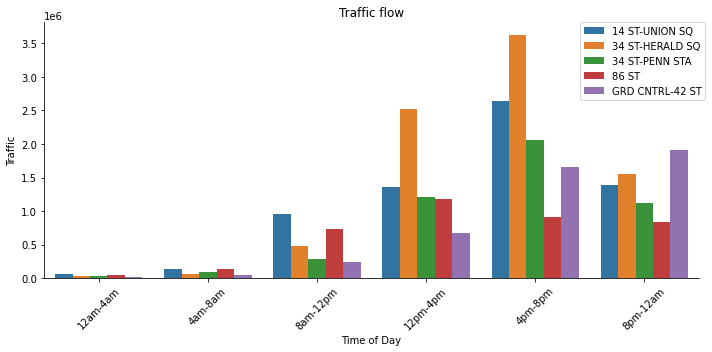

In [50]:
order = ['12am-4am','4am-8am','8am-12pm','12pm-4pm','4pm-8pm','8pm-12am']

flow_bar = sns.catplot('label','TOTAL_TRAFF',hue = 'STATION', kind = 'bar', data = top_stations, aspect = 2, order=order,legend = False)
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Traffic')
plt.title('Traffic flow')
plt.legend(bbox_to_anchor=(1.01,1),
           borderaxespad=0)
plt.tight_layout()
plt.savefig("Traffic_Time.png")

/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


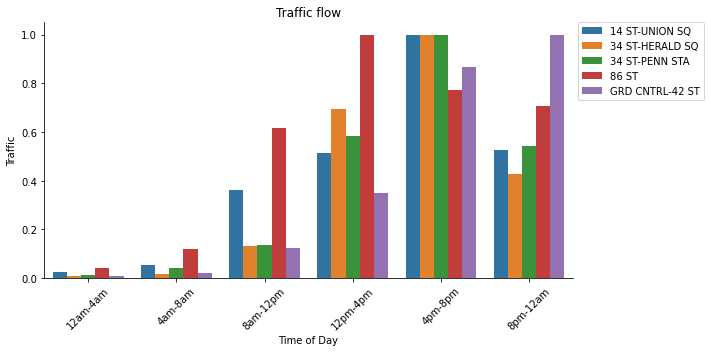

In [51]:
flow_bar = sns.catplot('label','% of PEAK',hue = 'STATION', kind = 'bar', data = top_stations, aspect = 2, order=order,legend=False)
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Traffic')
plt.title('Traffic flow')
plt.legend(bbox_to_anchor=(1.01,1),
           borderaxespad=0)
plt.tight_layout()
plt.savefig('Traffic_Time_Percent.png')